In [0]:
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50
import numpy as np
from keras.datasets import cifar10
import cv2
from keras import models
from keras import layers
from keras import optimizers
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt

In [2]:
conv_base = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
print(conv_base.summary())

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 75, 75, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

# Load Car dataset, License plate dataset and Labelled Faces in the Wild dataset

In [0]:
def extract_images(directory, sample_count):
    features = np.zeros((sample_count,150,150,3))
    labels = np.zeros((sample_count))
    generator = datagen.flow_from_directory(directory,target_size=(150,150),batch_size=batch_size,class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features[i*batch_size:(i+1)*batch_size] = inputs_batch
        labels[i*batch_size:(i+1)*batch_size] = labels_batch
        i += 1
        #print(i)
        if i*batch_size >= sample_count:
            break
    return features,labels

In [10]:
!wget http://imagenet.stanford.edu/internal/car196/cars_train.tgz

--2019-06-03 03:15:08--  http://imagenet.stanford.edu/internal/car196/cars_train.tgz
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 979269282 (934M) [application/x-gzip]
Saving to: ‘cars_train.tgz’

cars_train.tgz      100%[===================>] 933.90M  9.45MB/s    in 3m 11s  

2019-06-03 03:18:19 (4.89 MB/s) - ‘cars_train.tgz’ saved [979269282/979269282]



In [11]:
!wget http://imagenet.stanford.edu/internal/car196/cars_test.tgz

--2019-06-03 03:18:21--  http://imagenet.stanford.edu/internal/car196/cars_test.tgz
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977350468 (932M) [application/x-gzip]
Saving to: ‘cars_test.tgz’

cars_test.tgz       100%[===================>] 932.07M  6.15MB/s    in 4m 41s  

2019-06-03 03:23:02 (3.32 MB/s) - ‘cars_test.tgz’ saved [977350468/977350468]



In [12]:
!wget https://medusa.fit.vutbr.cz/traffic/download/512/

--2019-06-03 03:23:12--  https://medusa.fit.vutbr.cz/traffic/download/512/
Resolving medusa.fit.vutbr.cz (medusa.fit.vutbr.cz)... 147.229.8.49, 2001:67c:1220:808::93e5:831
Connecting to medusa.fit.vutbr.cz (medusa.fit.vutbr.cz)|147.229.8.49|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1908808499 (1.8G) [application/octet-stream]
Saving to: ‘index.html’

index.html          100%[===================>]   1.78G  26.7MB/s    in 69s     

2019-06-03 03:24:23 (26.3 MB/s) - ‘index.html’ saved [1908808499/1908808499]



In [4]:
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz

--2019-06-03 11:09:37--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180566744 (172M) [application/x-gzip]
Saving to: ‘lfw.tgz’

lfw.tgz             100%[===================>] 172.20M  70.4MB/s    in 2.4s    

2019-06-03 11:09:40 (70.4 MB/s) - ‘lfw.tgz’ saved [180566744/180566744]



In [0]:
import tarfile
car_train_zip = 'cars_train.tgz'
car_train_zip_ref = tarfile.open(car_train_zip, 'r')
car_train_zip_ref.extractall('cars_train')
car_train_zip_ref.close()

In [0]:
import tarfile
car_test_zip = 'cars_test.tgz'
car_test_zip_ref = tarfile.open(car_test_zip, 'r')
car_test_zip_ref.extractall('cars_test')
car_test_zip_ref.close()

In [0]:
import tarfile
lfw_zip = 'lfw.tgz'
lfw_zip_ref = tarfile.open(lfw_zip, 'r')
lfw_zip_ref.extractall('lfw')
lfw_zip_ref.close()

In [0]:
import zipfile

local_zip = 'index.html'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('plate')
zip_ref.close()

In [0]:
datagen = ImageDataGenerator()
batch_size = 50

In [5]:
train_car, train_car_labels = extract_images('cars_train',1000)

Found 8144 images belonging to 1 classes.


In [6]:
train_car_labels = np.ones((1000,1))*0
train_car_labels.shape

(1000, 1)

In [8]:
test_car, test_car_labels = extract_images('cars_test',200)

Found 8041 images belonging to 1 classes.


In [0]:
test_car_labels = np.ones((200,1))*0

In [11]:
plates, plates_labels = extract_images('plate',1200)

Found 185903 images belonging to 8 classes.


In [0]:
train_plate = plates[:1000]
test_plate = plates[1000:1200]

In [0]:
train_plate_labels = np.ones((1000,1))*1
test_plate_labels = np.ones((200,1))*1

In [14]:
lfw, lfw = extract_images('lfw',1200)

Found 13233 images belonging to 1 classes.


In [0]:
train_lfw = plates[:1000]
test_lfw = plates[1000:1200]

In [0]:
train_lfw_labels = np.ones((1000,1))*1
test_lfw_labels = np.ones((200,1))*1

# Merge 3 dataset to build a new dataset

In [18]:
x_train = np.concatenate((train_car,train_plate,train_lfw),axis=0)
y_train = np.concatenate((train_car_labels,train_plate_labels,train_lfw_labels))

x_test = np.concatenate((test_car,test_plate,test_lfw),axis=0)
y_test = np.concatenate((test_car_labels,test_plate_labels,test_lfw_labels))

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3000, 150, 150, 3)
(3000, 1)
(600, 150, 150, 3)
(600, 1)


In [39]:
y_cifa_train = to_categorical(y_cifa_train)
y_cifa_train.shape

(50000, 10)

In [40]:
y_cifa_test = to_categorical(y_cifa_test)
y_cifa_test.shape

(10000, 10)

In [0]:
datagen = ImageDataGenerator(rescale=1/255)

In [0]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [0]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
train_generator = train_datagen.flow(x_train,y_train, batch_size=32, shuffle=True)
test_generator = test_datagen.flow(x_test,y_test,batch_size=32,shuffle=True)

# Transfer learning

## Using Resnet50 to fine tune

In [0]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               26214912  
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 1539      
Total params: 49,804,163
Trainable params: 27,271,171
Non-trainable params: 22,532,992
_________________________________________________________________


In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'res5c_branch2c':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [35]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-3),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=10,
      validation_data=test_generator,
      validation_steps=50,
      callbacks=[ModelCheckpoint('car_plate_people.h5', monitor='val_acc', save_best_only=True)])

Epoch 1/10
100/100 [==============================] - 23s 229ms/step - loss: 0.0728 - acc: 0.9893 - val_loss: 2.3842e-07 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 17s 175ms/step - loss: 0.0665 - acc: 0.9955 - val_loss: 2.3842e-07 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 18s 175ms/step - loss: 0.0252 - acc: 0.9984 - val_loss: 2.3842e-07 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 18s 175ms/step - loss: 0.0201 - acc: 0.9987 - val_loss: 2.3842e-07 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 18s 177ms/step - loss: 0.0921 - acc: 0.9941 - val_loss: 2.3842e-07 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 18s 176ms/step - loss: 0.1160 - acc: 0.9928 - val_loss: 2.3842e-07 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 18s 176ms/step - loss: 0.0151 - acc: 0.9991 - val_loss: 2.3842e-07 - val_acc: 1.0000
Epoch 8/10
100/100 [=======

In [0]:
model.save('cars_plate_people.h5')

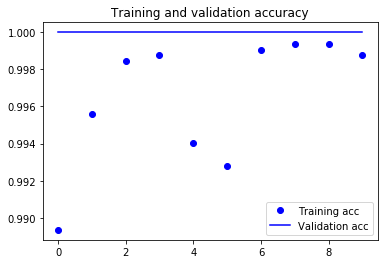

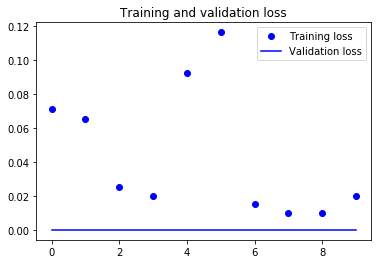

In [38]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
hi